In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from darwinian_shift import DarwinianShift, CDFMonteCarloTest, BinomTest

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
from darwinian_shift import FreeSASALookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import FoldXLookup, ANDLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [4]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"

# Colours
unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

In [5]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense', 
    statistics=CDFMonteCarloTest(num_draws=100000)
)

# Solvent accessibility

Exclude mutations on key functional sites (interface with DNA/ligands, calcium binding residues, key regions with mutations that activate the protein), and test if there is a shift in the distribution of solvent accessibility of the remaining mutations. 

First need to create the lookup classes to score and exclude the mutations.  

In [6]:
# A lookup for solvent accessibility.  
sa = FreeSASALookup(metric='total', pdb_directory=pdb_directory, sifts_directory=sifts_directory, 
                    download_pdb_file=True)

In [7]:
# Make a class to exclude mutations on key functional sites
focus_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean in/not in "focus" residues. 
    target_key='focus_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name=''  # Label to appear on plot axes
)

# And combine with the solvent accessibility class
# This will test for the distribution of solvent accessibility among mutations not on the functional sites
sa_excl = MutationExclusionLookup(
    lookup=sa, 
    exclusion_lookup=focus_lookup,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='SA'
)

In [8]:
# And make another class, this time to exclude mutations near to a molecule. 

# This measures the distance to the target
struct = StructureDistanceLookup(pdb_directory=pdb_directory, 
                            sifts_directory=sifts_directory)

# This converts to True/False if the distance is below or above the threshold
struct_bool = ANDLookup(lookups=[struct], thresholds=[8], directions=[-1])

# And this combines with the solvent accesibility
# This will test for the distribution of solvent accessibility among mutations distant from the target molecules
sa_excl2 = MutationExclusionLookup(
    lookup=sa, 
    exclusion_lookup=struct_bool,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='SA'
)

Define the key residues and the PDB structures to use for each protein. 

In [9]:
interface_residues = set([413, 415, 418, 420, 421, 422, 423, 424, 425, 
                         435, 436, 444, 447, 448, 450, 451, 452, 454, 
                         466, 467, 468, 469, 470, 471, 475, 477, 478, 
                         479, 480]) # defined in Luca et al 2017
ca_binding_residues = set([412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470])  # Defined by MetalPDB
focus_residues = interface_residues.union(ca_binding_residues)

notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'ca_binding_residues': ca_binding_residues,
    'interface_residues': interface_residues,
    'focus_residues': focus_residues,
}

In [10]:
interface_residues = set([418, 421, 424, 425, 426, 428, 429, 439, 440, 452, 454, 456, 470, 472, 473, 481]) 
ca_binding_residues = set([415, 416, 418, 435, 436, 439, 456, 457, 459, 473, 474]) 
focus_residues = interface_residues.union(ca_binding_residues)

notch2_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000256646', 'pdb_id': '5mwb', 'pdb_chain': 'A', 
    'start': 415, 'end': 492, # Restrict to the residues in EGF11-12
    'ca_binding_residues': ca_binding_residues,
    'interface_residues': interface_residues,
    'focus_residues': focus_residues
}

In [11]:
p53_dbd_section = {
    'transcript_id': 'ENST00000269305', 'pdb_id': '2ac0', 'pdb_chain': 'A', 
    'target_selection': 'segid E F G H'
}

In [12]:
# Residues in the three significantly selected regions of PIK3CA
selected_regions = np.concatenate([np.arange(100, 120), np.arange(444, 474), np.arange(962, 981)])

pik3ca_section_definition = {'transcript_id':'ENST00000263967', 'included_mutation_types': 'missense',
                            'pdb_id': '4l1b', 'pdb_chain': 'A', 
                             'focus_residues': selected_regions 
                            }

In [13]:
fbxw7_section_definition = {'gene': 'FBXW7', 'pdb_id': '2OVQ', 'pdb_chain': 'B', 'target_selection': 'protein and segid C'}

In [14]:
# Create a function to make the plot

from darwinian_shift.section import get_distribution_from_mutational_spectrum
import seaborn as sns

def get_combined_boxplot_data(sections):
    """
    Boxplot of the expected and observed distributions of mutation scores.
    :param spectra: The mutational spectrum or list of mutational spectra to use.
    :param plot_scale:  Scale for the y-axis (mutation scores). Passed to matplotlib. 'log', 'symlog' etc.
    :param show_plot: If True, will call plt.show().
    :param colours: List of colours. First colour is for the observed data, the subsequent colours are
    for plotting the null distributions from each of the mutational spectra given.
    :param figsize: Size of the figure.
    :param return_fig: If True, will return the figure. Used for testing.
    :param ax: Matplotlib axis to plot on. If None, will create a new figure.
    :return: By default, None. If return_fig=True, will return the figure.
    """
    data = []
    null_obs_labels = []
    genes = []
    
    for self in sections:
        spectrum = self._get_spectra(None)[0]
        
        null_dist = get_distribution_from_mutational_spectrum(self.null_scores,
                                                          self.null_mutations[spectrum.rate_column])
        data.extend(null_dist)
        null_obs_labels.extend(['null'] * len(null_dist))
        data.extend(self.observed_values)
        null_obs_labels.extend(['obs'] * self.num_mutations)
        
        genes.extend([self.gene] * (len(null_dist) + self.num_mutations))
        
    d = pd.DataFrame({'Solvent Accesibility': data, 
                     'null_obs': null_obs_labels, 
                     'gene': genes})
        
    return d
    


Calculate the expected and observed distributions of solvent accessibility in each protein. 

In [15]:
notch1 = d_skin.run_section(notch1_section_definition_egf11_12, lookup=sa_excl)

In [16]:
notch2 = d_skin.run_section(notch2_section_definition_egf11_12, lookup=sa_excl)

In [17]:
tp53 = d_skin.run_section(p53_dbd_section, lookup=sa_excl2)

In [18]:
pik3ca = d_skin.run_section(pik3ca_section_definition, lookup=sa_excl)

In [19]:
fbxw7 = d_skin.run_section(fbxw7_section_definition, lookup=sa_excl2)

In [20]:
boxplot_data = get_combined_boxplot_data([notch1, notch2, tp53, pik3ca, fbxw7])

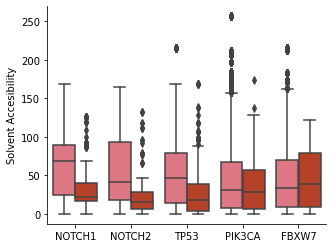

In [21]:
plt.figure(figsize=(5, 4))
p = sns.boxplot(data=boxplot_data, x='gene', y='Solvent Accesibility', hue='null_obs', dodge=True, 
               palette=[foldx_expected_colour, foldx_observed_colour])
p.legend_.remove()
hide_top_and_right_axes()
plt.xlabel("");

In [22]:
notch1.get_pvalues(), notch2.get_pvalues(), tp53.get_pvalues()

({'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05},
 {'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05},
 {'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05})

In [23]:
pik3ca.get_pvalues(), fbxw7.get_pvalues()

({'CDF_MC_glob_k3_pvalue': 0.28623713762862374},
 {'CDF_MC_glob_k3_pvalue': 0.7238727612723873})

# Enrichment of structure disrupting and functional site mutations

For each protein, calculate the observed/expected ratio of mutations that either disrupt the protein structure (destabilising mutations with high ∆∆G or mutations on calcium binding sites) or that are on key functional sites (protein-ligand interface, key regions in which activating mutations occur).   

A ratio above one shows an enrichment (likely positive selection) compared to the expected frequency, and a value below one is a depletion (likely negative selection).   

For each test, mutations in the other category are excluded to prevent the confounding effects of other selection. 

In [24]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

# Define a lookup object which determines whether mutations are on a ligand interface
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

# A lookup for calcium binding mutations.
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

# A lookup to define mutations with 8A of a target molecule in the PDB structure
struct = StructureDistanceLookup(pdb_directory=pdb_directory, 
                            sifts_directory=sifts_directory)

struct_bool = ANDLookup(lookups=[struct], thresholds=[8], directions=[-1])

## NOTCH1

In [25]:
fold_ca = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],
    directions=[1, 1], 
)

# Test for interface mutations (a function site), excluding the other categories
interface_excl = MutationExclusionLookup(
    lookup=interface_lookup, 
    exclusion_lookup=fold_ca,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='interface'
)

# Test for destabilising or calcium binding mutations, exluding interface mutations
fold_ca_excl = MutationExclusionLookup(
    lookup=fold_ca, 
    exclusion_lookup=interface_lookup,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='fold_ca'
)

In [26]:
notch1 = d_skin.run_section(notch1_section_definition_egf11_12, lookup=interface_excl, statistics=BinomTest())
res_int = notch1.get_results_dictionary()
ratio_interface = res_int['binom_glob_k3_observed_proportion']/res_int['binom_glob_k3_expected_proportion']

In [27]:
notch1_foldca = d_skin.run_section(notch1_section_definition_egf11_12, lookup=fold_ca_excl, statistics=BinomTest())
res_fc = notch1_foldca.get_results_dictionary()
ratio_fc = res_fc['binom_glob_k3_observed_proportion']/res_fc['binom_glob_k3_expected_proportion']

In [28]:
notch1_res = [ratio_interface, ratio_fc]

## NOTCH2

NOTCH2 can use the same lookup classes as NOTCH1

In [29]:
notch2 = d_skin.run_section(notch2_section_definition_egf11_12, lookup=interface_excl, statistics=BinomTest())
res_n2_int = notch2.get_results_dictionary()
ratio_n2_int = res_n2_int['binom_glob_k3_observed_proportion']/res_n2_int['binom_glob_k3_expected_proportion']

In [30]:
notch2 = d_skin.run_section(notch2_section_definition_egf11_12, lookup=fold_ca_excl, statistics=BinomTest())
res_n2_fold = notch2.get_results_dictionary()
ratio_n2_fold = res_n2_fold['binom_glob_k3_observed_proportion']/res_n2_fold['binom_glob_k3_expected_proportion']

In [31]:
notch2_res = [ratio_n2_int, ratio_n2_fold]

## TP53

In [32]:
# TP53 needs different lookups, that use the distance in the structure from the DNA molecule
interface_excl = MutationExclusionLookup(
    lookup=struct_bool, 
    exclusion_lookup=fold,   
    exclusion_threshold=2, 
    exclusion_direction=1,  
    name='interface'
)
fold_excl = MutationExclusionLookup(
    lookup=fold, 
    exclusion_lookup=struct_bool,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='fold'
)

In [33]:
p53 = d_skin.run_section(p53_dbd_section, lookup=interface_excl, statistics=BinomTest())
res_p53_int = p53.get_results_dictionary()
ratio_p53_int = res_p53_int['binom_glob_k3_observed_proportion']/res_p53_int['binom_glob_k3_expected_proportion']

In [34]:
p53 = d_skin.run_section(p53_dbd_section, lookup=fold_excl, statistics=BinomTest())
res_p53_fold = p53.get_results_dictionary()
ratio_p53_fold = res_p53_fold['binom_glob_k3_observed_proportion']/res_p53_fold['binom_glob_k3_expected_proportion']

In [35]:
p53_res = [ratio_p53_int, ratio_p53_fold]

## PIK3CA

In [36]:
focus_lookup = SequenceDistanceLookup(
    boolean=True,  
    target_key='focus_residues',  
    position_type='residue',  
)

focus_excl = MutationExclusionLookup(
    lookup=focus_lookup, 
    exclusion_lookup=fold,   
    exclusion_threshold=2, 
    exclusion_direction=1,  
)
fold_excl = MutationExclusionLookup(
    lookup=fold, 
    exclusion_lookup=focus_lookup,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
)

In [37]:
pik3ca = d_skin.run_section(pik3ca_section_definition, lookup=focus_excl, statistics=BinomTest())
res_pik_int = pik3ca.get_results_dictionary()
ratio_pik_int = res_pik_int['binom_glob_k3_observed_proportion']/res_pik_int['binom_glob_k3_expected_proportion']

In [38]:
pik3ca = d_skin.run_section(pik3ca_section_definition, lookup=fold_excl,  statistics=BinomTest())
res_pik_fold = pik3ca.get_results_dictionary()
ratio_pik_fold = res_pik_fold['binom_glob_k3_observed_proportion']/res_pik_fold['binom_glob_k3_expected_proportion']

In [39]:
pik3ca_res = [ratio_pik_int, ratio_pik_fold]

## FBXW7

In [41]:
interface_excl = MutationExclusionLookup(
    lookup=struct_bool, 
    exclusion_lookup=fold,   
    exclusion_threshold=2, 
    exclusion_direction=1,  
    name='interface'
)
fold_excl = MutationExclusionLookup(
    lookup=fold, 
    exclusion_lookup=struct_bool,   
    exclusion_threshold=0.5, 
    exclusion_direction=1,  
    name='fold'
)

In [43]:
fbxw7 = d_skin.run_section(fbxw7, lookup=interface_excl, statistics=BinomTest())
res_fb_int = fbxw7.get_results_dictionary()
ratio_fb_int = res_fb_int['binom_glob_k3_observed_proportion']/res_fb_int['binom_glob_k3_expected_proportion']

/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_36606/3079415017.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ratio_fb_int = res_fb_int['binom_glob_k3_observed_proportion']/res_fb_int['binom_glob_k3_expected_proportion']


In [44]:
fbxw7 = d_skin.run_section(fbxw7, lookup=fold_excl, statistics=BinomTest())
res_fb_fold = fbxw7.get_results_dictionary()
ratio_fb_fold = res_fb_fold['binom_glob_k3_observed_proportion']/res_fb_fold['binom_glob_k3_expected_proportion']

/Users/mh28/PycharmProjects/darwinian_shift/darwinian_shift/section.py:247: FutureWarning: Passing 'suffixes' which cause duplicate columns {'score_x'} in the result is deprecated and will raise a MergeError in a future version.
  self.observed_mutations = pd.merge(self.observed_mutations,


In [45]:
fbxw7_res = [ratio_fb_int, ratio_fb_fold]

## Plot

In [46]:
def hide_top_and_right_and_left_axes(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('none')

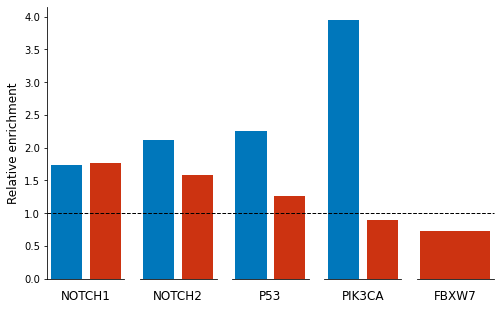

In [47]:
names = [0, 1]
y_off = -0.1

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(8, 5))
colours = [interface_observed_colour, foldx_observed_colour]

axes[0].set_title("NOTCH1", y=y_off)
axes[0].bar(names, notch1_res, color=colours)
axes[1].set_title("NOTCH2", y=y_off)
axes[1].bar(names, notch2_res, color=colours)
axes[2].set_title("P53", y=y_off)
axes[2].bar(names, p53_res, color=colours)
axes[3].set_title("PIK3CA", y=y_off)
axes[3].bar(names, pik3ca_res, color=colours)
axes[4].set_title("FBXW7", y=y_off)
axes[4].bar(names, fbxw7_res, color=colours)

hide_top_and_right_axes(axes[0])
axes[0].set_xticks([])
for ax in axes[1:]:
    hide_top_and_right_and_left_axes(ax)
    ax.set_xticks([])
    
axes[0].set_ylabel("Relative enrichment", fontsize=12)

axes[4].axhline(y=1,xmin=-4.8,xmax=1,c="k", linestyle='--', linewidth=1, zorder=10,clip_on=False);

# Correlation of misfolding missense and nonsense selection

In [48]:
# Here we need to specify the transcripts to analyse explicitly because the default option (longest transcript)
# does not match the canonical sequence (and the structure sequence) for PTPRT
transcript_list = [list(v)[0] for k,v in d_skin.gene_transcripts_map.items() if k != 'PTPRT']
transcript_list.append('ENST00000373187') # The canonical PTPRT transcript from uniprot

# Load the data again, this will not load the correct exons for PTPRT, allowing the structure to be analysed. 
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense', 
    statistics=CDFMonteCarloTest(num_draws=100000),
    transcript_list=transcript_list
)

In [49]:
dnds = pd.read_csv('skin_dndscv_full_results.txt', sep="\t")

In [50]:
structures_run = pd.read_csv("FoldX_results/structures_run.txt", sep="\t")

In [51]:
res = []
for i, row in structures_run.iterrows():
    s = d_skin.run_section(row, lookup=fold, statistics=CDFMonteCarloTest(num_draws=100000))
    res.append(s.get_results_dictionary())

res = pd.DataFrame(res)

In [52]:
z_shifts = res.groupby('gene').agg(['mean', 'sem'])['CDF_MC_glob_k3_cdf_mean']

In [53]:
merged = pd.merge(z_shifts, dnds, left_index=True, right_on='gene_name')

In [54]:
merged['shift'] = merged['mean'] - 0.5

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/seaborn/regression.py:301: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


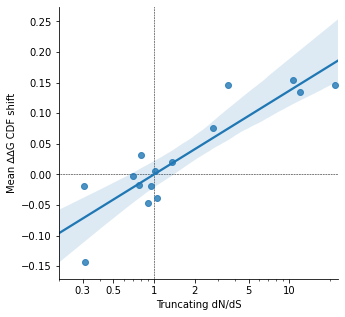

In [55]:
plt.figure(figsize=(5, 5))
sns.regplot(data=merged, y='shift', x='wnon_cv', logx=True, truncate=False)
plt.xscale('log')

plt.xticks([0.3, 0.5, 1, 2, 5, 10], [0.3, 0.5, 1, 2, 5, 10])
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([1, 1], [-5, 5], 'k--', linewidth=0.5, zorder=-1)
plt.plot([-10, 50], [0, 0], 'k--', linewidth=0.5, zorder=-1)
plt.xlim(xlim)
plt.xlim(left=0.2)
plt.ylim(ylim)
plt.ylabel('Mean ∆∆G CDF shift')
plt.xlabel('Truncating dN/dS')
hide_top_and_right_axes()